In [ ]:
from dotenv import load_dotenv
import os

from kaggle.api.kaggle_api_extended import KaggleApi

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Cargar el archivo .env
load_dotenv()

# Inicializa la API de Kaggle
api = KaggleApi()
api.authenticate()

# Descarga un dataset
dataset = 'stealthtechnologies/predict-student-performance-dataset'  # Cambia por el dataset que desees

dataset_folder = dataset.split(sep='/')[-1]

output_path = f'datasets/{dataset_folder}/'  # Carpeta donde se descargará
api.dataset_download_files(dataset, path=output_path, unzip=True)

df = pd.read_csv(f'{output_path}/data.csv')
df

True

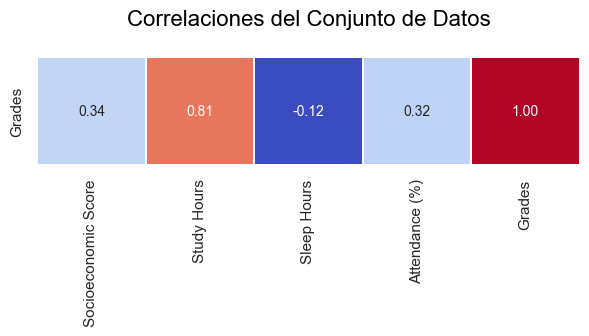

In [56]:
sns.set_theme(font_scale=1)
sns.set_style('white')

cols = df.columns.values
cm = np.corrcoef(df.values.T)

plt.figure(figsize=(7,7))
hm = sns.heatmap(cm[[4]], cbar=False, annot=True, square=True, fmt=".2f", annot_kws={"size":10,},
                 cmap="coolwarm", linewidths=.3, yticklabels=[cols[4]], xticklabels=cols)
hm.set_title('Correlaciones del Conjunto de Datos\n', size=16, color='black')
plt.show()

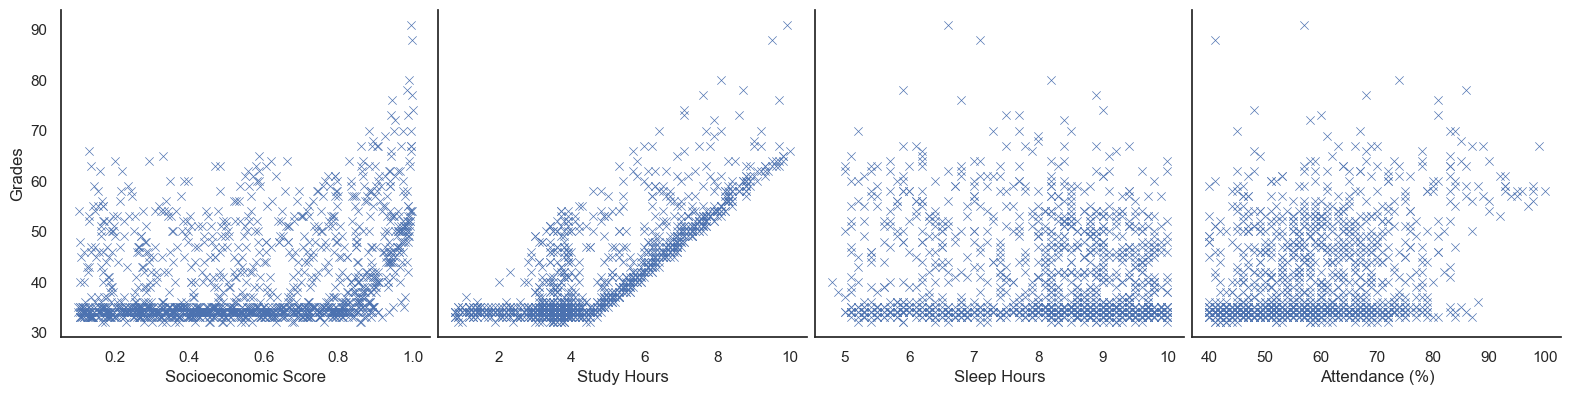

In [57]:
sns.pairplot(data=df,x_vars=cols[:-1],y_vars=['Grades'],height=4.0, aspect=1, markers='x')

In [45]:
x = df.drop('Grades',axis=1)
y = df['Grades']

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.7,random_state=7)

rf = RandomForestRegressor()
model = rf.fit(x_train, y_train)
r2_score = model.score(x_test, y_test)

print(r2_score)


0.9782006742021057


In [ ]:
results = pd.DataFrame(columns=['Dataset'])

results['Real_Grades'] = df['Grades']
results['Model_Predict'] = model.predict(x)

# Añadir la columna 'Dataset' con 'Train' o 'Test'
results['Dataset'] = 'Train'  # Inicializa con 'Train'
results.loc[x_test.index, 'Dataset'] = 'Test'

results['Perc_Accuracy'] = results['Model_Predict']/(results['Real_Grades'])
results['Diff'] = results['Model_Predict'] - results['Real_Grades']
results['Error'] = results.apply(lambda row: 'Subestimado' if row['Perc_Accuracy']<0.95
                                else('Preciso' if row['Perc_Accuracy']>=0.95 and row['Perc_Accuracy']<=1.05
                                    else('Sobreestimado' if row['Perc_Accuracy']>1.05 else 0)), axis=1)

results['Error_Diff'] = results.apply(lambda row: 'Subestimado' if row['Diff']<-2
                                else('Preciso' if row['Diff']>=-2 and row['Diff']<=2
                                    else('Sobreestimado' if row['Diff']>2. else 0)), axis=1)

results

,Dataset,Real_Grades,Model_Predict
0,Train,47.0,46.76
1,Train,35.0,35.42
2,Train,32.0,32.88
3,Test,34.0,34.26
4,Train,33.0,33.45
...,...,...,...
1383,Train,41.0,40.41
1384,Train,37.0,36.72
1385,Test,36.0,38.98
1386,Train,34.0,34.09


In [64]:
df_resume = results.groupby(by=['Dataset']).apply(
        lambda group: pd.Series({
            'Subestimado (%)': round(100 * len(group[(group['Error'] == 'Subestimado')]) / len(group), 1),
            'Preciso (%)': round(100 * len(group[(group['Error'] == 'Preciso')]) / len(group), 1),
            'Sobreestimado (%)': round(100 * len(group[(group['Error'] == 'Sobreestimado')]) / len(group), 1),
        }), include_groups=False
    ).reset_index()

df_resume

,Dataset,Subestimado,Preciso,Sobreestimado
0,Test,3.6,92.1,4.3
1,Train,0.0,99.9,0.1


In [65]:
df_resume = results.groupby(by=['Dataset']).apply(
        lambda group: pd.Series({
            'Subestimado (%)': round(100 * len(group[(group['Error_Diff'] == 'Subestimado')]) / len(group), 1),
            'Preciso (%)': round(100 * len(group[(group['Error_Diff'] == 'Preciso')]) / len(group), 1),
            'Sobreestimado (%)': round(100 * len(group[(group['Error_Diff'] == 'Sobreestimado')]) / len(group), 1),
        }), include_groups=False
    ).reset_index()

df_resume

,Dataset,Subestimado (%),Preciso (%),Sobreestimado (%)
0,Test,5.3,88.7,6.0
1,Train,0.6,99.2,0.2
